In [2]:
# === CELL 1: Data Loading and Graph Construction ===
from Bio import SeqIO
import pandas as pd
import networkx as nx

# Load FASTA
fasta_path = "../Data/top_2000_sequences.faa"
fasta_records = list(SeqIO.parse(fasta_path, "fasta"))
print(f"Total protein sequences loaded: {len(fasta_records)}")

# Load STRING interactions
string_df = pd.read_csv("../Data/string_interactions.tsv", sep='\t')
G = nx.Graph()
for _, row in string_df.iterrows():
    G.add_edge(row["#node1"], row["node2"], weight=row["combined_score"])
print(f"✅ Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Preview
print("Sample edges:", list(G.edges(data=True))[:5])

# Load Biomni CSV
biomni_df = pd.read_csv("../Data/complete_vaccine_analysis_all_3257_proteins.csv").set_index("protein_id")
feature_cols = [
    "signal_peptide_strength", "number_of_tm_domains", "cysteine_content",
    "gravy_hydrophobicity", "protein_length", "molecular_weight_da",
    "instability_index", "isoelectric_point", "vaccine_score"
]
priority_map = {"Very Low": 0, "Low": 1, "Medium": 2, "High": 3}

for node in G.nodes:
    if node in biomni_df.index:
        row = biomni_df.loc[node]
        G.nodes[node]['features'] = row[feature_cols].values.astype(float)
        G.nodes[node]['priority'] = priority_map.get(row['priority'], -1)
    else:
        G.nodes[node]['features'] = None
        G.nodes[node]['priority'] = -1

Total protein sequences loaded: 2000
✅ Graph loaded: 1607 nodes, 16315 edges
Sample edges: [('AEW84859.2', 'sdhA', {'weight': 0.409}), ('AEW84859.2', 'atpD', {'weight': 0.413}), ('AEW84859.2', 'AEW85750.1', {'weight': 0.452}), ('AEW84859.2', 'dnaJ', {'weight': 0.457}), ('AEW84859.2', 'AEW86571.1', {'weight': 0.467})]


In [3]:
# === CELL 2: Remap Node IDs ===
mapping_df = pd.read_csv("../Data/string_mapping.tsv", sep="\t")
mapping_df.columns = mapping_df.columns.str.replace('#', '')
string_to_fasta_map = dict(zip(mapping_df['preferredName'], mapping_df['queryItem']))
G_remapped = nx.relabel_nodes(G, string_to_fasta_map, copy=True)

# Attach features to remapped graph
missing = 0
for node in G_remapped.nodes:
    if node in biomni_df.index:
        row = biomni_df.loc[node]
        G_remapped.nodes[node]['features'] = row[feature_cols].values.astype(float)
        G_remapped.nodes[node]['priority'] = priority_map.get(row['priority'], -1)
    else:
        G_remapped.nodes[node]['features'] = None
        G_remapped.nodes[node]['priority'] = -1
        missing += 1

# Add isolated proteins
isolated_count = 0
for string_id, fasta_id in string_to_fasta_map.items():
    if fasta_id not in G_remapped:
        G_remapped.add_node(fasta_id)
        if fasta_id in biomni_df.index:
            row = biomni_df.loc[fasta_id]
            G_remapped.nodes[fasta_id]["features"] = row[feature_cols].values.astype(float)
            G_remapped.nodes[fasta_id]["priority"] = priority_map.get(row["priority"], -1)
        else:
            G_remapped.nodes[fasta_id]["features"] = None
            G_remapped.nodes[fasta_id]["priority"] = -1
        G_remapped.nodes[fasta_id]["isolated"] = True
        isolated_count += 1
print(f"✅ Added {isolated_count} isolated proteins to the graph.")

✅ Added 37 isolated proteins to the graph.


In [4]:
# === CELL 3: PyG Conversion & Edge Splitting ===
import torch
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling

sorted_nodes = list(G_remapped.nodes)
node_to_idx = {node: i for i, node in enumerate(sorted_nodes)}
features, labels = [], []
for node in sorted_nodes:
    data = G_remapped.nodes[node]
    feat = data.get("features", [0.0]*len(feature_cols))
    features.append(feat)
    labels.append(data.get("priority", -1))

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
edge_index = torch.tensor([
    [node_to_idx[u], node_to_idx[v]] for u, v in G_remapped.edges()
], dtype=torch.long).t().contiguous()

pyg_graph = Data(x=x, edge_index=edge_index, y=y)
pyg_graph.node_names = sorted_nodes

# Edge splitting
torch.manual_seed(42)
num_edges = edge_index.size(1)
perm = torch.randperm(num_edges)
split = int(0.9 * num_edges)
train_pos = edge_index[:, perm[:split]]
test_pos = edge_index[:, perm[split:]]
test_neg = negative_sampling(edge_index=edge_index, num_nodes=x.size(0), num_neg_samples=test_pos.size(1))
print(f"✅ PyG graph ready. Nodes: {x.size(0)}, Edges: {edge_index.size(1)}")


✅ PyG graph ready. Nodes: 1644, Edges: 16315


/var/tmp/pbs.438357.bright04/ipykernel_909753/2007925081.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor(features, dtype=torch.float)


In [5]:
# === CELL 1: Define GNN Architectures ===
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Shared link predictor (dot product)
class LinkPredictor(nn.Module):
    def forward(self, z, edge_index):
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=-1)


In [21]:
# === CELL 2 (Updated): Training with Best Fold Selection ===

hidden_dim_list = [32, 64]
lr_list = [0.01, 0.001]

def train_and_evaluate(model_class, model_name, x, edge_index, pyg_graph, folds=3,
                       hidden_dim_list=[32, 64], lr_list=[0.01, 0.001], epochs=50):
    
    results_dir = os.path.join("..", "Results", model_name)
    os.makedirs(results_dir, exist_ok=True)
    
    all_results = []
    best_global_auc = 0
    best_global_fold = -1
    best_global_model = None
    best_global_z = None

    for fold in range(folds):
        print(f"\n🔁 Fold {fold+1}/{folds} for {model_name}")
        
        torch.manual_seed(42 + fold)
        num_edges = edge_index.size(1)
        perm = torch.randperm(num_edges)
        split = int(0.9 * num_edges)
        train_pos = edge_index[:, perm[:split]]
        test_pos = edge_index[:, perm[split:]]
        test_neg = negative_sampling(edge_index=edge_index, num_nodes=x.size(0), num_neg_samples=test_pos.size(1))
        
        best_auc = 0
        best_log = ""
        
        for hidden_dim in hidden_dim_list:
            for lr in lr_list:
                model = model_class(x.size(1), hidden_dim).to(device)
                predictor = LinkPredictor().to(device)
                optimizer = optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=lr)
                
                for epoch in range(epochs):
                    model.train()
                    predictor.train()

                    z = model(x, edge_index)

                    pos_score = predictor(z, train_pos)
                    pos_label = torch.ones_like(pos_score)

                    train_neg = negative_sampling(edge_index, pyg_graph.num_nodes, train_pos.size(1)).to(device)
                    neg_score = predictor(z, train_neg)
                    neg_label = torch.zeros_like(neg_score)

                    score = torch.cat([pos_score, neg_score])
                    label = torch.cat([pos_label, neg_label])

                    loss = F.binary_cross_entropy_with_logits(score, label)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Eval
                    model.eval()
                    z = model(x, edge_index)
                    with torch.no_grad():
                        test_score_pos = torch.sigmoid(predictor(z, test_pos))
                        test_score_neg = torch.sigmoid(predictor(z, test_neg))
                        test_scores = torch.cat([test_score_pos, test_score_neg])
                        test_labels = torch.cat([
                            torch.ones(test_score_pos.size(0)),
                            torch.zeros(test_score_neg.size(0))
                        ])
                        auc = roc_auc_score(test_labels.cpu(), test_scores.cpu())

                    log_line = f"[{model_name}][Fold {fold+1}] Epoch {epoch+1}/{epochs}, Hidden={hidden_dim}, LR={lr}, Loss={loss.item():.4f}, Test AUC={auc:.4f}"
                    print(log_line)

                    if auc > best_auc:
                        best_auc = auc
                        best_log = log_line
                        best_model = model
                        best_z = z.detach().clone()

        # Save per-fold best
        fold_log_path = os.path.join(results_dir, f"training_fold{fold+1}.txt")
        with open(fold_log_path, "w") as f:
            f.write(best_log + "\n")

        torch.save(best_z.cpu(), os.path.join(results_dir, f"embeddings_fold{fold+1}.pt"))
        all_results.append((fold+1, best_auc, best_log))

        # Update global best
        if best_auc > best_global_auc:
            best_global_auc = best_auc
            best_global_fold = fold + 1
            best_global_z = best_z.detach().clone()

    # Save best fold info
    with open(os.path.join(results_dir, "best_fold.txt"), "w") as f:
        f.write(f"{best_global_fold}\n")

    torch.save(best_global_z.cpu(), os.path.join(results_dir, f"embeddings_best.pt"))
    print(f"\n🏆 Best fold for {model_name}: Fold {best_global_fold} (AUC={best_global_auc:.4f})")

    return {
        "model": model_name,
        "best_fold": best_global_fold,
        "best_auc": best_global_auc,
        "results": all_results
    }


In [22]:
# === CELL 3: Train All GNN Architectures ===
import torch
import os
import torch.optim as optim
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure data is on the correct device
x = pyg_graph.x.to(device)
edge_index = pyg_graph.edge_index.to(device)

# Run training and capture results
results_sage = train_and_evaluate(GraphSAGE, "GraphSAGE", x, edge_index, pyg_graph)
results_gcn  = train_and_evaluate(GCN,      "GCN",      x, edge_index, pyg_graph)
results_gat  = train_and_evaluate(GAT,      "GAT",      x, edge_index, pyg_graph)

# Optional: Display best fold summary
print("\n=== 🏁 Best Fold Summary ===")
for res in [results_sage, results_gcn, results_gat]:
    print(f"{res['model']}: Fold {res['best_fold']} | Best AUC: {res['best_auc']:.4f}")



🔁 Fold 1/3 for GraphSAGE
[GraphSAGE][Fold 1] Epoch 1/50, Hidden=32, LR=0.01, Loss=679645312.0000, Test AUC=0.5107
[GraphSAGE][Fold 1] Epoch 2/50, Hidden=32, LR=0.01, Loss=274075584.0000, Test AUC=0.5135
[GraphSAGE][Fold 1] Epoch 3/50, Hidden=32, LR=0.01, Loss=118336560.0000, Test AUC=0.5104
[GraphSAGE][Fold 1] Epoch 4/50, Hidden=32, LR=0.01, Loss=80479248.0000, Test AUC=0.5077
[GraphSAGE][Fold 1] Epoch 5/50, Hidden=32, LR=0.01, Loss=74920344.0000, Test AUC=0.5074
[GraphSAGE][Fold 1] Epoch 6/50, Hidden=32, LR=0.01, Loss=64244648.0000, Test AUC=0.5077
[GraphSAGE][Fold 1] Epoch 7/50, Hidden=32, LR=0.01, Loss=54843060.0000, Test AUC=0.5083
[GraphSAGE][Fold 1] Epoch 8/50, Hidden=32, LR=0.01, Loss=46824308.0000, Test AUC=0.5080
[GraphSAGE][Fold 1] Epoch 9/50, Hidden=32, LR=0.01, Loss=41901432.0000, Test AUC=0.5098
[GraphSAGE][Fold 1] Epoch 10/50, Hidden=32, LR=0.01, Loss=39060948.0000, Test AUC=0.5098
[GraphSAGE][Fold 1] Epoch 11/50, Hidden=32, LR=0.01, Loss=35697292.0000, Test AUC=0.5107
[

In [23]:
# === CELL 4 (Updated): Analyze using best fold embeddings ===

def analyze_model_best(model_name):
    print(f"\n🔎 Analyzing predicted links for {model_name} (Best Fold)")

    # Load best fold index
    best_fold_path = f"../Results/{model_name}/best_fold.txt"
    with open(best_fold_path, "r") as f:
        best_fold = int(f.read().strip())

    # Load best embeddings
    z = torch.load(f"../Results/{model_name}/embeddings_best.pt", map_location=device).to(device)

    # Identify isolated and connected nodes
    isolated_nodes = [n for n, d in G_remapped.nodes(data=True) if d.get("isolated") is True]
    connected_nodes = [n for n in G_remapped.nodes if n not in isolated_nodes]

    # Build candidate edges
    node_to_idx = {name: i for i, name in enumerate(pyg_graph.node_names)}
    idx_to_node = {i: name for name, i in node_to_idx.items()}
    candidate_edges = []

    for iso in isolated_nodes:
        for conn in connected_nodes:
            u, v = node_to_idx[iso], node_to_idx[conn]
            if not G_remapped.has_edge(iso, conn):
                candidate_edges.append((u, v))

    for u, v in itertools.combinations(isolated_nodes, 2):
        idx_u, idx_v = node_to_idx[u], node_to_idx[v]
        if not G_remapped.has_edge(u, v):
            candidate_edges.append((idx_u, idx_v))

    candidate_edge_tensor = torch.tensor(candidate_edges, dtype=torch.long).t().contiguous().to(device)

    # Predict scores
    predictor = LinkPredictor().to(device)
    predictor.eval()
    with torch.no_grad():
        scores = predictor(z, candidate_edge_tensor)
#        probs = sigmoid(scores)
        probs = F.sigmoid(scores)


    # Filter high-confidence edges
    threshold = 0.90
    mask = probs >= threshold
    filtered_edges = candidate_edge_tensor[:, mask]
    filtered_probs = probs[mask]

    top_k = 1000
    if filtered_edges.size(1) > top_k:
        top_vals, top_idx = torch.topk(filtered_probs, top_k)
        final_edges = filtered_edges[:, top_idx]
    else:
        final_edges = filtered_edges

    # Priority pairing analysis
    priority_dict = {name: G_remapped.nodes[name].get("priority", -1) for name in G_remapped.nodes}
    class_pair_counter = Counter()

    for i in range(final_edges.size(1)):
        u_idx, v_idx = final_edges[0, i].item(), final_edges[1, i].item()
        u_name, v_name = idx_to_node[u_idx], idx_to_node[v_idx]
        u_priority, v_priority = priority_dict[u_name], priority_dict[v_name]
        pair_key = tuple(sorted((u_priority, v_priority)))
        class_pair_counter[pair_key] += 1

    # Build and save table
    priority_labels = ["Very Low", "Low", "Medium", "High"]
    table = pd.DataFrame(0, index=priority_labels, columns=priority_labels)
    for (a, b), count in class_pair_counter.items():
        a_label, b_label = priority_labels[a], priority_labels[b]
        table.loc[a_label, b_label] += count
        if a != b:
            table.loc[b_label, a_label] += count

    table_path = f"../Results/{model_name}/priority_link_table_best.csv"
    table.to_csv(table_path)

    # Save heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(table, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
    plt.title(f"Predicted Link Heatmap - {model_name} (Best Fold)")
    plt.xlabel("Priority Class B")
    plt.ylabel("Priority Class A")
    plt.tight_layout()
    heatmap_path = f"../Results/{model_name}/heatmap_best.png"
    plt.savefig(heatmap_path)
    plt.close()

    print(f"✅ Saved table to: {table_path}")
    print(f"✅ Saved heatmap to: {heatmap_path}")


In [24]:
# === CELL 5: Run Analysis for All Models (Fold 1) ===
import itertools
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns



# Run for all models using their best fold embeddings
for model in ["GraphSAGE", "GCN", "GAT"]:
    analyze_model_best(model)



🔎 Analyzing predicted links for GraphSAGE (Best Fold)


/var/tmp/pbs.438357.bright04/ipykernel_909753/2285740272.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load(f"../Results/{model_name}/embeddings_best.pt", m

✅ Saved table to: ../Results/GraphSAGE/priority_link_table_best.csv
✅ Saved heatmap to: ../Results/GraphSAGE/heatmap_best.png

🔎 Analyzing predicted links for GCN (Best Fold)


/var/tmp/pbs.438357.bright04/ipykernel_909753/2285740272.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load(f"../Results/{model_name}/embeddings_best.pt", m

✅ Saved table to: ../Results/GCN/priority_link_table_best.csv
✅ Saved heatmap to: ../Results/GCN/heatmap_best.png

🔎 Analyzing predicted links for GAT (Best Fold)


/var/tmp/pbs.438357.bright04/ipykernel_909753/2285740272.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load(f"../Results/{model_name}/embeddings_best.pt", m

✅ Saved table to: ../Results/GAT/priority_link_table_best.csv
✅ Saved heatmap to: ../Results/GAT/heatmap_best.png


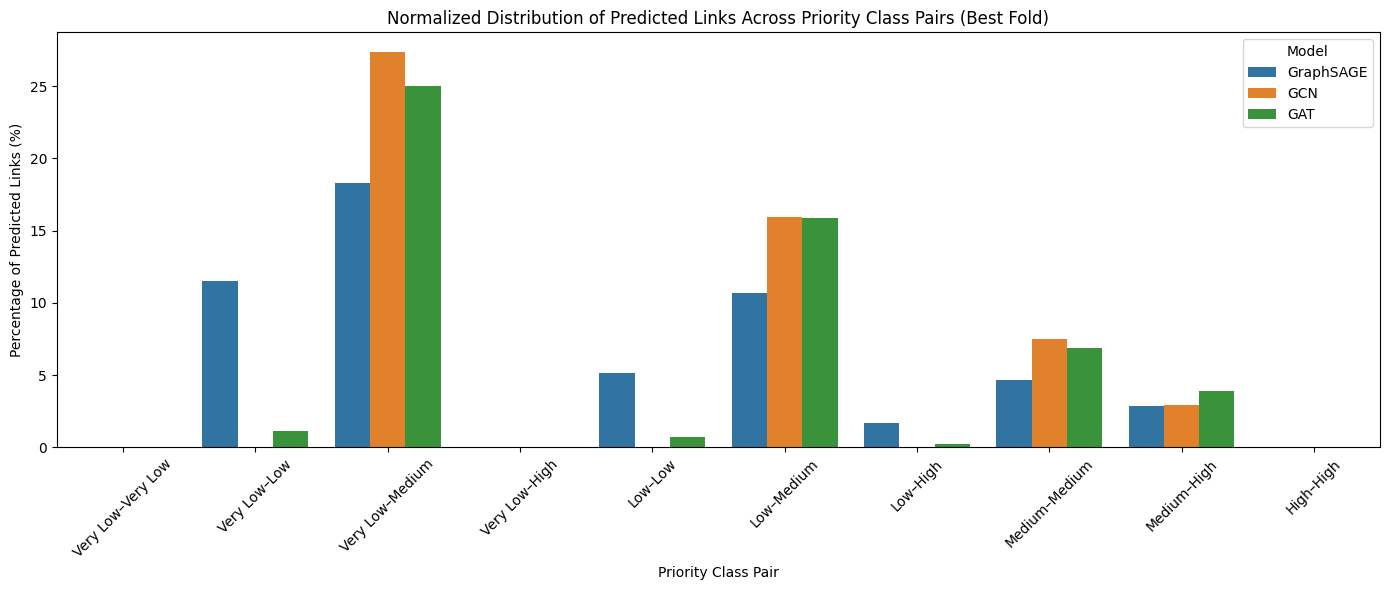

In [25]:
# === CELL 6: Normalized Grouped Bar Chart for Best Fold ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved tables
def load_table(model_name):
    path = f"../Results/{model_name}/priority_link_table_best.csv"
    return pd.read_csv(path, index_col=0)

tables = {
    "GraphSAGE": load_table("GraphSAGE"),
    "GCN": load_table("GCN"),
    "GAT": load_table("GAT")
}

priority_labels = ["Very Low", "Low", "Medium", "High"]

# Flatten and collect class-pair data
all_data = []
for model, table in tables.items():
    total_links = table.values.sum()
    for i in range(len(priority_labels)):
        for j in range(i, len(priority_labels)):
            pair = f"{priority_labels[i]}–{priority_labels[j]}"
            count = table.iloc[i, j]
            percent = 100 * count / total_links if total_links > 0 else 0
            all_data.append({
                "Class Pair": pair,
                "Model": model,
                "Percentage": percent
            })

df = pd.DataFrame(all_data)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="Class Pair", y="Percentage", hue="Model")
plt.title("Normalized Distribution of Predicted Links Across Priority Class Pairs (Best Fold)")
plt.xticks(rotation=45)
plt.ylabel("Percentage of Predicted Links (%)")
plt.xlabel("Priority Class Pair")
plt.tight_layout()
plt.show()
